<a href="https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/04%20investment%20portfolios%20with%20DCF.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

You can run the code examples in [Google Colab](https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/03%20investment%20portfolios.ipynb).

**To install the package:**

In [ ]:
import okama.portfolios.cashflow_strategies
!pip install okama

import okama and matplotlib packages ...

In [94]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

Сlass **Portfolio** can be used to define the basic investment strategy (without cash flow).

In [95]:
pf = ok.Portfolio(
    ["SPY.US", "AGG.US", "GLD.US"],
    weights=[0.60, 0.35, 0.05],
    ccy="USD",
    inflation=True,
    last_date="2024-01",
    rebalancing_strategy=ok.Rebalance(period="year"),
    symbol="My_portfolio.PF",
)
pf

symbol                                My_portfolio.PF
assets                       [SPY.US, AGG.US, GLD.US]
weights                             [0.6, 0.35, 0.05]
rebalancing_period                               year
rebalancing_abs_deviation                        None
rebalancing_rel_deviation                        None
currency                                          USD
inflation                                    USD.INFL
first_date                                    2004-12
last_date                                     2024-01
period_length                      19 years, 2 months
dtype: object

## Set up Cash Flow strategy

Cash flow parameters for investment portfolios can be configured in the corresponding classes:

- `IndexationStrategy` for strategies with regular indexed withdrawals / contributions
- `PercentageStrategy` for strategies weith regualr fixed percentage withdrawals / contributions
- `TimeSeriesStrategy` for strategies with user-defined withdrawals and contributions. Withdrawals, contributions, as well as their dates, are defined in the dictionary.

## IndexationStrategy: regular indexed withdrawals or contributions

`IndexationStrategy` class can be used to set up a cash flow strategy where contributions or withdrawals to portfolio are made with a certain frequency.  All contributions can be indexed each period.

In [96]:
ind = okama.portfolios.portfolio.cashflow_strategy.IndexationStrategy(pf)  # create IndexationStrategy linked to the Portfolio

Set up the cash flow parameters.

In [97]:
ind.initial_investment = 10_000  # the initial investments size
ind.amount = -2_500  # set withdrawal size
ind.frequency = "year"  # set cash flow frequency
ind.indexation = "inflation"  # set indexation equal to mean inflation
ind

Portfolio symbol                My_portfolio.PF
Cash flow initial investment              10000
Cash flow frequency                        year
Cash flow strategy                 fixed_amount
Cash flow amount                          -2500
Cash flow indexation                   0.025322
dtype: object

Assign the strategy to Portfolio.

In [98]:
pf.dcf.cashflow_parameters = ind  # assign the cash flow strategy to portfolio

### Backtest the Portfolio with cash flow

We can start by verifying the strategy on historical data. 

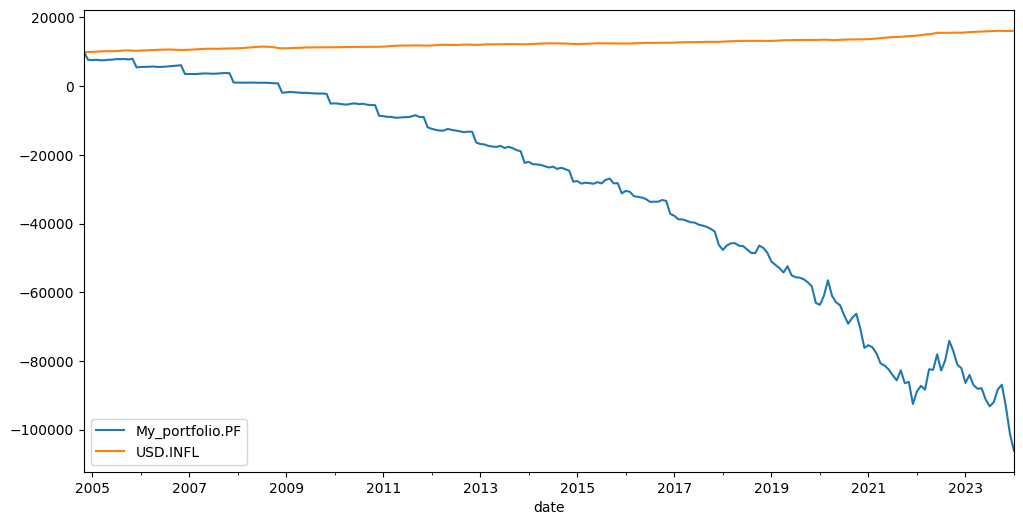

In [99]:
pf.dcf.wealth_index(discounting="fv", include_negative_values=False).plot();

It's easy to see that the portfolio balance is voided fast. The "survival period" is 4.2 years. The withdrawal size is too big.

In [100]:
pf.dcf.survival_period_hist()

4.1

To get the date of when the portfolio balance reduced to 0 we can use `survival_date_hist()`

In [101]:
pf.dcf.survival_date_hist()

Timestamp('2008-12-31 00:00:00')

Let's change the withdrawal size...

In [102]:
pf.dcf.cashflow_parameters.amount = -600

<Axes: xlabel='date'>

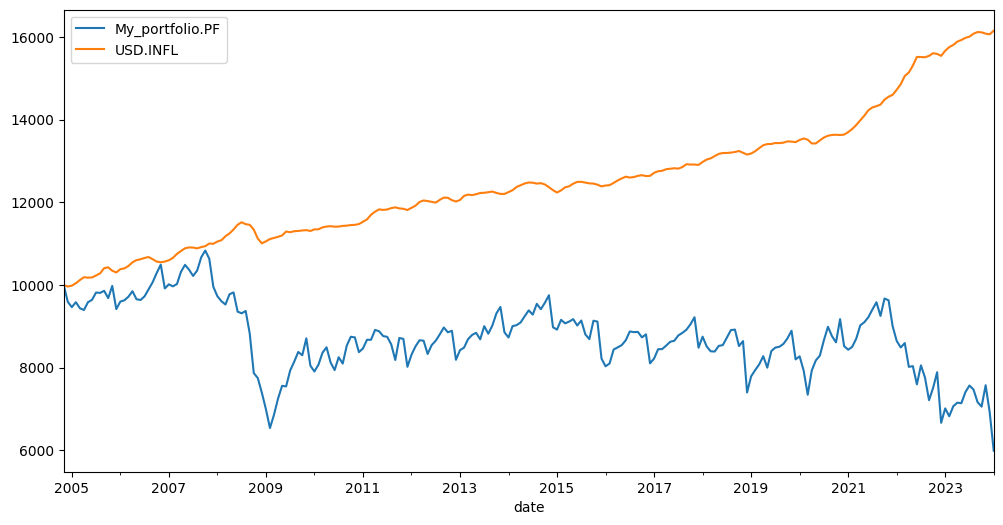

In [103]:
pf.dcf.wealth_index(discounting="fv", include_negative_values=False).plot()

With new withdrawal size the portfolio successfully pass backtesting even though the balance is below the inflation. 

The size of the initial investment in 2004 (the beginning of the historical data period) is 10,000. However, the purchasing power of money 20 years ago was different.   
It depends on `discount_rate` parameter.

In [104]:
pf.dcf.discount_rate = 0.07  # set discount rate to 7%

If not defined, the `discount_rate` is the inflation rate or (if there is not inflation data) the discount default value - 5%.

The discounted size of the initial investment on `first_date` can be found with `initial_investment_pv`:

In [105]:
pf.dcf.initial_investment_pv

2746.4382960214607

If we want to start backtesting a strategy with a discounted initial investment and withdrawal amount, then it is enough to change the value of the `use_discounted_values` parameter.

In [106]:
pf.dcf.use_discounted_values = True

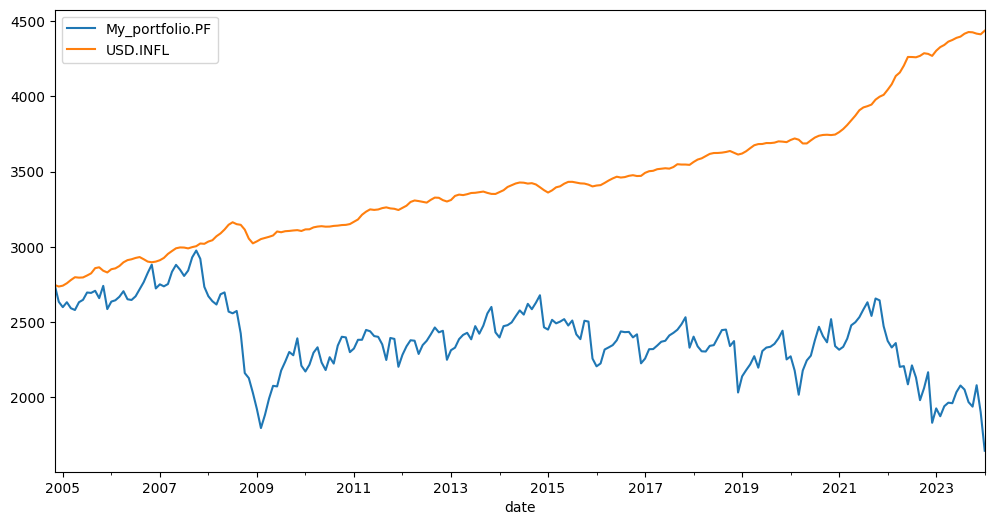

In [107]:
pf.dcf.wealth_index(discounting="fv", include_negative_values=False).plot();

When the withdrawal size -500 (5% of the initial investments) the portfolio balance lasts for all 19 years of backtest period. But will it work in the future? Is it an optimal withdrawal size?

To answer these questions, we can use Monte Carlo simulation. This will help testing the strategy on multiple scenarios (not just one, as in a backtest).

### Monte Carlo simulation

First we need to set up Monte Carlo simulation parameters:

In [108]:
pf.dcf.set_mc_parameters(
    distribution="norm",  # Normal distribution (or Gaussian distribution)
    period=60,  # the forecasting period is 10 years
    number=400,  # generate 400 random simulations
)

in this case we use popular normal distribution to generate random rate of return series in Monte Carlo scenarios. However, there are other distribution types. How to backtest and select optimal distribution we discuss in [08 backtesting distribution.ipynb](https://github.com/mbk-dev/okama/blob/master/examples/08%20backtesting%20distribution.ipynb).

With Monte Carlo parameters we can test the future outcomes.

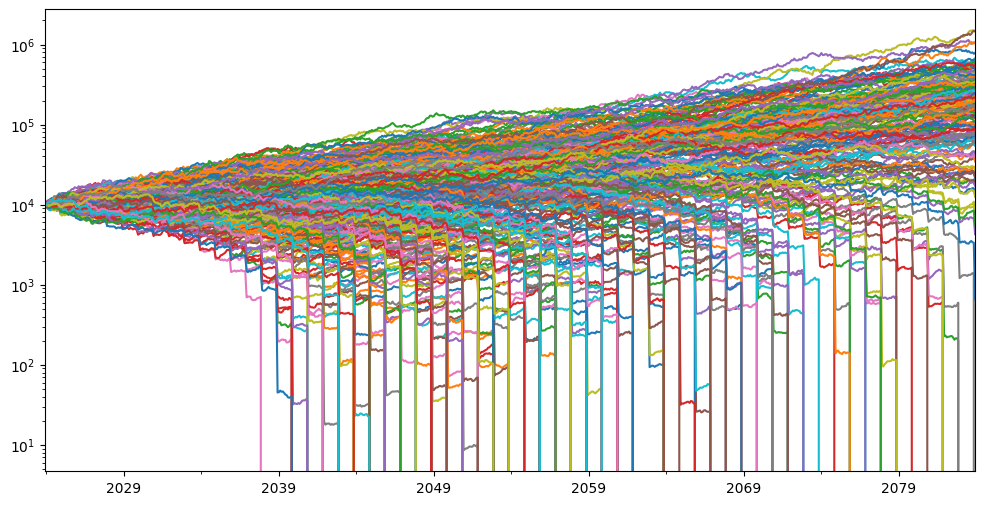

In [109]:
pf.dcf.plot_forecast_monte_carlo(backtest=False)
plt.yscale("log")  # set logarithmic scale for Y-axis to see negative scenarios

We see in the chart that many scenarios were optimistic (portfolio balance was positive even after 60 years), and some other were negative (the portfolio balance is voided). 

With `monte_carlo_survival_period` we can get more statistical details about survival period.

In [110]:
s = pf.dcf.monte_carlo_survival_period()  # get all survival periods for random scenarios for our settings
s

0      25.0
1      21.0
2      24.0
3      18.0
4      36.0
       ... 
395    22.0
396    27.0
397    32.0
398    60.0
399    21.0
Length: 400, dtype: float64

In [111]:
s.min()  # the worst survival period from generated scenarios

np.float64(15.0)

In [112]:
s.quantile(5 / 100)  # survival period for worst 5% of scenarios (5th percentile)

np.float64(18.0)

In [113]:
s.quantile(25 / 100)  # survival period for worst 25% of scenarios (25th percentile)

np.float64(26.0)

In [114]:
s.quantile(50 / 100)  # survival period for median (50th percentile)

np.float64(39.0)

`find_the_largest_withdrawals_size()` method helps to find the largest withdrawal size for a cash flow strategy. 

There can be 3 types of goals:

- **survival_period**: to keep positive balance for a given period
- **maintain_balance_pv**: to keep the purchasing power of the invesments after inflation for the whole period defined in Monte Carlo parameters
- **maintain_balance_fv**: to maintain the balance not lower than the nominal amount of the initial investment after inflation for the whole period defined in Monte Carlo parameteres.

*WARNING: this method can be slow for large Monte Carlo scenarios.*

In [115]:
result = pf.dcf.find_the_largest_withdrawals_size(
    goal="survival_period",  # The goal of the strategy in this case is to keep the portfolio alive for a given survival period
    target_survival_period=30,  # the target period when the portfolio balance is not voided by withdrawals and market volatility
    percentile=25,  # The percentile of Monte Carlo distribution where the goal is achieved. The 25th percentile is a negative scenario.
)

sp_at_quantile=2.00, main_parameter=-10000.000
error_rel=0.933, gradient=0.000
decreasing withdrawal
sp_at_quantile=3.00, main_parameter=-5000.000
error_rel=0.900, gradient=-0.033
decreasing withdrawal
sp_at_quantile=5.00, main_parameter=-2500.000
error_rel=0.833, gradient=-0.067
decreasing withdrawal
sp_at_quantile=10.00, main_parameter=-1250.000
error_rel=0.667, gradient=-0.167
decreasing withdrawal
sp_at_quantile=24.00, main_parameter=-625.000
error_rel=0.200, gradient=-0.467
decreasing withdrawal
sp_at_quantile=60.00, main_parameter=-312.500
error_rel=1.000, gradient=0.800
increasing withdrawal
sp_at_quantile=39.00, main_parameter=-468.750
error_rel=0.300, gradient=-0.700
increasing withdrawal
sp_at_quantile=31.00, main_parameter=-546.875
error_rel=0.033, gradient=-0.267
solution found: -546.88 or 5.47% after 8 steps.


In the result the 'withdrawal_abs' is the absolute value of the withdrawal (the first withdrawal value).

In [116]:
result.withdrawal_abs

-546.875

The 'withdrawal_rel' is the relative withdrawal size (the first withdrawal value divided by the initial investment).

In [117]:
result.withdrawal_rel

0.0546875

If the solution was not found it's still possible to see the intermediate steps.

In [118]:
result.solutions

,withdrawal_abs,withdrawal_rel,error_rel,error_rel_change
0,-10000.0,1.0,0.933333,0
1,-5000.0,0.5,0.9,-0.033333
2,-2500.0,0.25,0.833333,-0.066667
3,-1250.0,0.125,0.666667,-0.166667
4,-625.0,0.0625,0.2,-0.466667
5,-312.5,0.03125,1.0,0.8
6,-468.75,0.046875,0.3,-0.7
7,-546.875,0.054688,0.033333,-0.266667


## PercentageStrategy: regular fixed percentage withdrawals or contributions

In fixed percentage cash flow strategy withdrawals or contributions are a percentage of balance each period. Many know "4% rule" for withdrawals. But in this case we can test with any percentage.

In [119]:
pc = okama.portfolios.portfolio.cashflow_strategy.PercentageStrategy(pf)  # create PercentageStrategy linked to the portfolio

In [120]:
pc.initial_investment = 10_000  # initial investments size
pc.frequency = "year"  # withdrawals frequency
pc.percentage = -0.12  # the percentage of withdrawals is 8%
pc

Portfolio symbol                 My_portfolio.PF
Cash flow initial investment               10000
Cash flow frequency                         year
Cash flow strategy              fixed_percentage
Cash flow percentage                       -0.12
dtype: object

In [121]:
pf.dcf.cashflow_parameters = pc  # assign the cash flow strategy to portfolio

A 12% withdrawal rate substantially exceeds the commonly recommended 4%. Let's check if this strategy "survive" backtesting.

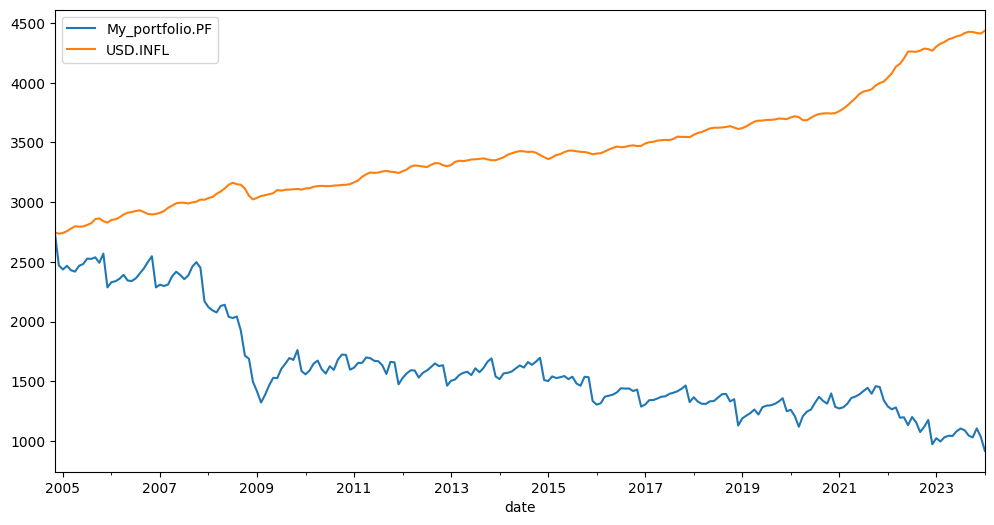

In [122]:
pf.dcf.wealth_index(discounting="fv", include_negative_values=False).plot();

This strategy significantly reduced the balance of the investment portfolio. However, it's not voided after almost 20 years.  


In [123]:
pf.dcf.wealth_index_fv["My_portfolio.PF"].iat[-1]

np.float64(919.64456249914)

How many years such strategy can survive in the future?

### Monte Carlo simulation

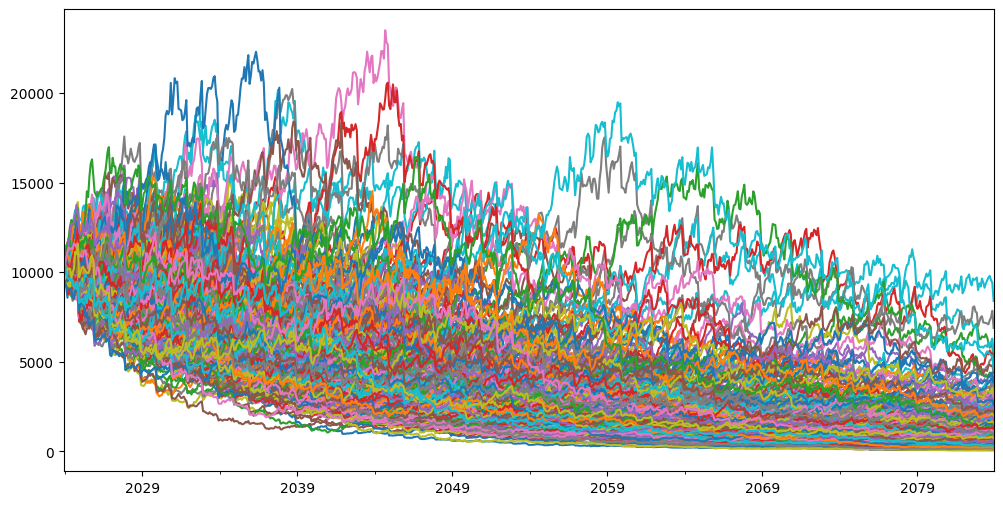

In [124]:
pf.dcf.plot_forecast_monte_carlo(backtest=False)

In fixed percentage strategy the balance never voids. It can be very small, but the strategy still will be able to withdraw the fixed percentage.   
`threshold` parameter helps to define when the balance is considered equal to zero.  
`threshold` is defined as a percentage of the initial investments when the portfolio balance considered voided.

In [125]:
s = pf.dcf.monte_carlo_survival_period(threshold=0.05)  # threshold is set to 5%

In [126]:
s.describe()

count    400.000000
mean      26.438250
std        4.936835
min       14.600000
25%       23.000000
50%       26.000000
75%       29.000000
max       48.000000
dtype: float64

Most scenarios (50th percentile) have positive balance for 20+ years. However in this scenario, portfolio withdrawals decrease each period as the balance declines.

What if our goal is to leave a legacy? We want to withdraw as much money from the portfolio as possible so that its purchasing power does not decrease. We can find the maximum withdrawal rate that meets these conditions, again using the `find_the_largest_withdrawals_size` method. The `goal` parameter should be changed to `maintain_balance_pv`.  

But first we need to reduce the `period` in Monte Carlos settings. In the simulation the size of portfolio is considered at the end of period. Usually it should not be too long (30 years here).

In [127]:
pf.dcf.set_mc_parameters(distribution="norm", period=30, number=400)  # simulation period in years

After 30 years the balance present value (PV) should be not less then initial investments: 

In [128]:
pf.dcf.cashflow_parameters.initial_investment

10000

We should also reset the discount value to the size of long term mean of inflation. The balance PV is affected by the discount size (for 7% it would be very low).

In [129]:
pf.dcf.discount_rate = None
pf.dcf

Portfolio symbol             My_portfolio.PF
Monte Carlo distribution                norm
Monte Carlo period                        30
Cash flow strategy          fixed_percentage
use_discounted_values                   True
discount_rate                       0.025322
dtype: object

In [130]:
result = pf.dcf.find_the_largest_withdrawals_size(
    goal="maintain_balance_pv",  # The goal of the strategy in this case is to keep the portfolio's real balance (for the whole period)
    percentile=25,  # The percentile of Monte Carlo result distribution where the goal is to be achieved. The 25th percentile is a negative scenario.
    threshold=0.10,  # 10% - is the percentage of initial investments when the portfolio balance is considered voided.
    iter_max=50,  # The maximum number of iterations to find the solution.
    tolerance_rel=0.15,  # The allowed tolerance for the solution. The tolerance is the largest error for the achieved goal.
)

the goal is maintain_balance_pv
wealth_at_quantile=0.00, main_parameter=-1.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
the goal is maintain_balance_pv
wealth_at_quantile=0.00, main_parameter=-0.500
error_rel=1.000, gradient=-0.000
decreasing withdrawal
the goal is maintain_balance_pv
wealth_at_quantile=8.74, main_parameter=-0.250
error_rel=0.999, gradient=-0.001
decreasing withdrawal
the goal is maintain_balance_pv
wealth_at_quantile=673.59, main_parameter=-0.125
error_rel=0.933, gradient=-0.066
decreasing withdrawal
the goal is maintain_balance_pv
wealth_at_quantile=4550.70, main_parameter=-0.062
error_rel=0.545, gradient=-0.388
decreasing withdrawal
the goal is maintain_balance_pv
wealth_at_quantile=12082.04, main_parameter=-0.031
error_rel=0.208, gradient=-0.337
increasing withdrawal
the goal is maintain_balance_pv
wealth_at_quantile=7425.92, main_parameter=-0.047
error_rel=0.257, gradient=0.049
decreasing withdrawal
the goal is maintain_balance_pv
wealth_at_quantile=9

In [131]:
result.withdrawal_rel

0.0390625

In this example we see that annual withdrawals of 3,9% will help to maintain the portfolio balance (keep the purchasing power) after 30 years.  

If the goal is to maintain the nominal balance (not the purchasing power) of the portfolio after 30 years. Then the withdrawal size can be higher.

In [132]:
result = pf.dcf.find_the_largest_withdrawals_size(
    goal="maintain_balance_fv",  # The goal of the strategy in this case is to keep the portfolio's nominal balance (the size of the initial investments)
    percentile=25,  # The percentile of Monte Carlo result distribution where the goal is to be achieved. The 25th percentile is a negative scenario.
    threshold=0.10,  # 10% - is the percentage of initial investments when the portfolio balance is considered voided.
    iter_max=50,  # The maximum number of iterations to find the solution.
    tolerance_rel=0.15,  # The allowed tolerance for the solution. The tolerance is the largest error for the achieved goal.
)

the goal is maintain_balance_fv
wealth_at_quantile=0.00, main_parameter=-1.000
error_rel=1.000, gradient=0.000
decreasing withdrawal
the goal is maintain_balance_fv
wealth_at_quantile=0.00, main_parameter=-0.500
error_rel=1.000, gradient=-0.000
decreasing withdrawal
the goal is maintain_balance_fv
wealth_at_quantile=20.13, main_parameter=-0.250
error_rel=0.998, gradient=-0.002
decreasing withdrawal
the goal is maintain_balance_fv
wealth_at_quantile=1525.11, main_parameter=-0.125
error_rel=0.847, gradient=-0.150
decreasing withdrawal
the goal is maintain_balance_fv
wealth_at_quantile=10131.39, main_parameter=-0.062
error_rel=0.013, gradient=-0.834
solution found: -625.00 or 6.25% after 5 steps.


In [133]:
result.withdrawal_rel

0.0625

## TimeSeriesStrategy: user-defined withdrawals and contributions

`TimeSeriesStrategy` helps to study scenarios with an arbitrary set of withdrawals and contributions. Their size and dates are specified by the user in the form of a dictionary.  
Let's create a new poerfolio with fixed first and last dates to define better the timeframe where we see the historical data.

In [134]:
pf2 = ok.Portfolio(first_date="2015-01", last_date="2024-10")  # create Portfolio with default ticker (SPY.US)
pf2

symbol                        portfolio_3479.PF
assets                                 [SPY.US]
weights                                   [1.0]
rebalancing_period                        month
rebalancing_abs_deviation                  None
rebalancing_rel_deviation                  None
currency                                    USD
inflation                              USD.INFL
first_date                              2015-01
last_date                               2024-10
period_length                9 years, 10 months
dtype: object

Now we can create a simple dictionary with cash flow amounts and dates.

In [135]:
d = {"2018-02": 2_000, "2024-03": -4_000}  # contribution  # withdrawal

Then we create `TimeSeriesStrategy` linked to the portfolio and use the dictionary to set the cash flow.

In [136]:
ts = okama.portfolios.portfolio.cashflow_strategy.TimeSeriesStrategy(pf2)
ts.time_series_dic = d  # use the dictionary to set cash flow

It's possible also to define initial investments. It's optional but usually some kind of investment occurs on the first date of the period.

In [137]:
ts.initial_investment = 1_000  # add initial investments size (optional)

Assign the cash flow strategy to portfolio.

In [138]:
pf2.dcf.cashflow_parameters = ts

### Backtest the Portfolio

The dates in the dictionary are in the past. Therefore this set of cash flows can be used for backtesting (for Monte Carlo we define another dictionary with the future dates).

In [139]:
pf2.dcf.wealth_index_fv

,portfolio_3479.PF,USD.INFL
2014-12,1000.000000,1000.000000
2015-01,970.400000,995.300000
2015-02,1024.936480,999.579790
2015-03,1008.844977,1005.577269
2015-04,1018.731658,1007.588423
...,...,...
2024-06,3417.265627,1338.211780
2024-07,3458.614541,1339.817634
2024-08,3539.546121,1340.889488
2024-09,3613.876590,1343.034911


### Monte Carlo simulation

For Monte Carlo simulation we should define another dates in the future (or the simulation will test the strategy without cash flows).

In [140]:
d = {"2027-02": 2_000, "2034-03": -4_000}  # contribution  # withdrawal

The most important event is large withdrawal in 2034. How likely is it that the portfolio balance will withstand this withdrawal?

Create the `TimeSeriesStrategy` and assign it to Portfolio. The initial investments in this scenario is 1,000. Then we add another 2,000 (3,000 in total) and hope to withdraw 4,000 in 2034.

In [141]:
ts2 = okama.portfolios.portfolio.cashflow_strategy.TimeSeriesStrategy(pf2)
ts2.time_series_dic = d  # use the dictionary to set cash flow
ts2.initial_investment = 1_000
pf2.dcf.cashflow_parameters = ts2

Now we can test the future scenarios with Monte Carlo simulation after setting the parameters.

In [142]:
pf2.dcf.set_mc_parameters(
    distribution="norm",  # Normal distribution (or Gaussian distribution)
    period=30,  # the forecasting period is 30 years
    number=500,  # generate 500 random simulations
)

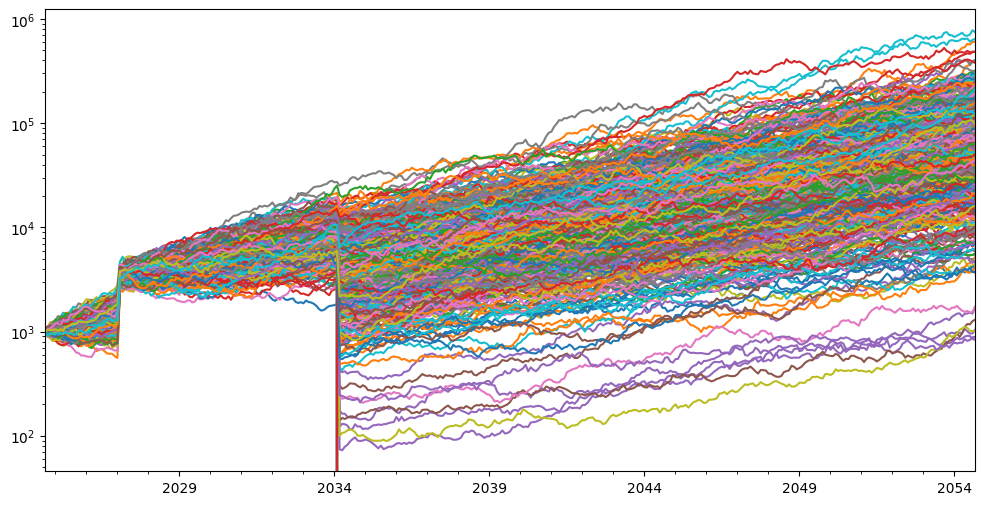

In [143]:
pf2.dcf.plot_forecast_monte_carlo(backtest=False)
plt.yscale("log")  # we use logarithmic scale to see better the negative scenarios

The chart shows that most scenarios are optimistic. The balance is reduced significantly, but many portfolios survive after 30 years test period.    

In [144]:
s = pf2.dcf.monte_carlo_survival_period(threshold=0.10)  # the balance is considered voided when it drops to 10%.

In [145]:
s.describe([0.05, 0.25, 0.50])

count    500.000000
mean      28.934000
std        4.556112
min        9.500000
5%         9.500000
25%       30.000000
50%       30.000000
max       30.000000
dtype: float64

Only in 5% of random scenarios the balance of portfolio is voided (reduced to 10% o below). The 25th and 50th shows that in most scenarios the portfolio is alive after 30 years. 